# Project: Food Classification Convolutional Neural Network
CS-UY 4563
Kyle Ng & Connie Zhou

In [125]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, Activation, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import os
from shutil import copyfile

# Split Train and Test Data
The Food101 dataset gives class names in the meta/meta/classes.txt. A train and test directory was created for each class name. The dataset also provides the filenames of pre-split train and test images. These images were copied to the corresponding directories.

In [148]:
classes = [] # fill with class names

# create train and test directories for each class
with open('food41/meta/meta/classes.txt', 'r') as fp:
    line = fp.readline()
    while line:
        classes.append(line)
        line = line.strip()
        try:
            os.makedirs('train/'+line)
        except FileExistsError:
            # directory already exists
            pass
        try:
            os.makedirs('test/'+line)
        except FileExistsError:
            # directory already exists
            pass
        line = fp.readline()
        
# move training images to corresponding folders
with open('food41/meta/meta/train.txt', 'r') as fp:
    line = fp.readline()
    while line:
        line = line.strip()
        dir = "train/" + line.split('/')[0]
        if os.path.isdir(dir):
            src = 'food41/images/' + line + '.jpg'
            dst = 'train/' + line + '.jpg'
            copyfile(src, dst)
        line = fp.readline()

# move testing images to corresponding folders
with open('food41/meta/meta/test.txt', 'r') as fp:
    line = fp.readline()
    while line:
        line = line.strip()
        dir = "test/" + line.split('/')[0]
        if os.path.isdir(dir):
            src = 'food41/images/' + line + '.jpg'
            dst = 'test/' + line + '.jpg'
            copyfile(src, dst)
        line = fp.readline()

# Using Generators to Load Data
The ImageDataGenerator class was used to deal with the large amount of images in batches. This also enabled the use of data augmentation and multithreading.

In [127]:
# set size of images
nrow = 128
ncol = 128

# train generator
train_data_dir = './train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

# test generator
test_data_dir = './test'
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Display Image
The following function displays the inputted image.

In [128]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

# Sample Display Images
Images generated from train_generator and their corresponding label are shown.

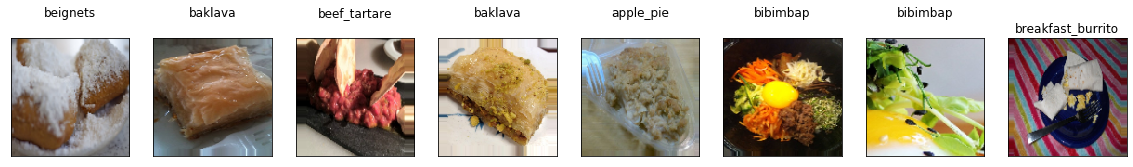

In [146]:
# sample minibatch
X,y = train_generator.next()
plt.figure(figsize=(20,20))
nplot = 8
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    disp_image(X[i])
    plt.title(classes[int(y[i])])

# Train Model
A new Sequential model was created. Conv2D was used for 2D convolution, MaxPool2D for pooling to down sample, and Dropout for regularization to reduce overfitting.

In [131]:
# build model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(np.max(y)+2))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
activation_66 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_67 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 63, 63, 64)      

# Train Model
The model was compiled with an rmsprop optimizer, sparse_categorical_crossentropy loss function, and accuracy metrics. The model was fit for 5 epochs using fit_generator.

In [133]:
# train model
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size
nepochs = 5  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/5
234/234 [==============================] - 512s 2s/step - loss: 2.2293 - accuracy: 0.2248 - val_loss: 1.7725 - val_accuracy: 0.3986
Epoch 2/5
234/234 [==============================] - 480s 2s/step - loss: 1.8633 - accuracy: 0.3555 - val_loss: 1.5989 - val_accuracy: 0.4447
Epoch 3/5
234/234 [==============================] - 465s 2s/step - loss: 1.7376 - accuracy: 0.3902 - val_loss: 1.6007 - val_accuracy: 0.4431
Epoch 4/5
234/234 [==============================] - 469s 2s/step - loss: 1.6419 - accuracy: 0.4344 - val_loss: 1.4430 - val_accuracy: 0.5064
Epoch 5/5
234/234 [==============================] - 453s 2s/step - loss: 1.5665 - accuracy: 0.4499 - val_loss: 1.5457 - val_accuracy: 0.4611


# Plot Accuracy
The accuracy metrics were taken from the model history.

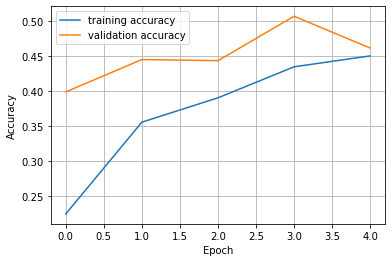

In [135]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(['training accuracy','validation accuracy'])
plt.show()

# Sample Error Images
Some images that were misclassified from a generated minibatch are shown.

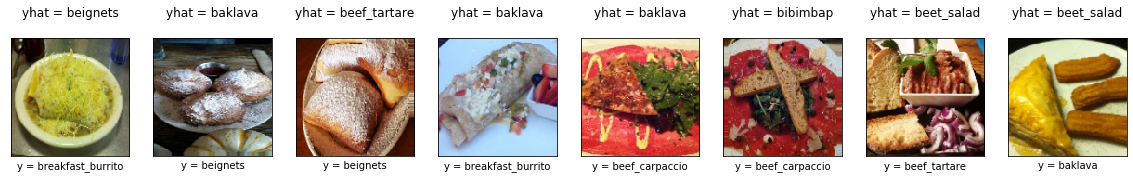

In [150]:
test_generator.reset()
nplot = 8
nfound = 0
Xerr = []
ytrue = []
yhat = []
while (nfound < nplot):
    Xts, yts = test_generator.next()
    y_pred = model.predict_classes(X).ravel()
    I = np.where(y_pred != yts)[0]
    for i in I:
        Xerr.append(Xts[i])
        ytrue.append(yts[i])
        yhat.append(y_pred[i])
        nfound += 1
plt.figure(figsize=(20,10))
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    disp_image(Xerr[i])
    plt.title("yhat = "+classes[int(yhat[i])])
    plt.xlabel("y = "+classes[int(ytrue[i])])